# 画像データ分析チートシート

本稿に利用するデータは下記の日本古典に描かれたキャラクターの顔貌画像を、最先端テクノロジーで分類する画像分類コンペ

https://competition.nishika.com/competitions/kaokore_pra/summary

### Google Driveをマウント



In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/ 'My Drive'/nishika/training_日本絵画顔分類

Mounted at /content/drive
/content/drive/ My Drive/nishika/training_日本絵画顔分類


In [2]:
# colaboratry内にないライブラリをインストール
!pip install japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 20.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=8d465f6fcabbd759b7a1cb6a5eca1a9f3256245b04f59eeb53fc24fa7e88fd01
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


### データの準備

データをダウンロードして、下記のように格納

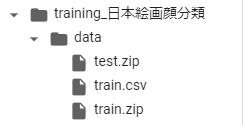

In [3]:
# zipファイルの解凍（すでに解凍済みの場合はスルー）
import os
if not os.path.exists('./data/train_images/'):
    import zipfile
    file_path = './data/train.zip'
    if os.path.exists(file_path):
        with zipfile.ZipFile(file_path) as existing_zip:
            existing_zip.extractall('./data/train_images')
    else:
        print(f"The file {file_path} does not exist.")
        file_path = './data/train.zip'

In [4]:
# ライブラリインポート
import pandas               as pd  # ある意味の主役
import matplotlib.pyplot    as plt # グラフ表示
import japanize_matplotlib         # 日本語表示用
japanize_matplotlib.japanize()

import torch
from   torchvision             import datasets
from   torchvision.transforms  import transforms
from   torchvision.datasets    import ImageFolder
from   torch.utils.data        import Dataset, DataLoader, random_split
from   PIL                     import Image

In [5]:
# CSVファイルの読み込み
csvFilePath  = './data/train.csv'
data = pd.read_csv(csvFilePath)

In [6]:
data.head()

,image,gender_status
0,n_00001.jpg,4
1,n_00002.jpg,0
2,n_00003.jpg,0
3,n_00005.jpg,0
4,n_00006.jpg,0


In [7]:
# わかりやすいようにラベル（数字）とラベル名（日本語）の対応表を辞書を作る
# https://competition.nishika.com/competitions/kaokore_pra/dataから'gender_status'のラベル名を確認
LABELDICT = {
    0:'0:男-貴族',
    1:'1:男-武士',
    2:'2:男-化身',
    3:'3:男-庶民',
    4:'4:女-貴族',
    5:'5:女-武士',
    6:'6:女-化身',
    7:'7:女-庶民'
  }

In [8]:
# ラベル名を付与
data['labelname'] = data['gender_status'].apply(lambda x: LABELDICT[x])

# 読み込んだcsvのimageパスを解凍先設定
data['imagePath'] = data['image'].apply(lambda x: './data/train_images/train/' + x)
data.head()

,image,gender_status,labelname,imagePath
0,n_00001.jpg,4,4:女-貴族,./data/train_images/train/n_00001.jpg
1,n_00002.jpg,0,0:男-貴族,./data/train_images/train/n_00002.jpg
2,n_00003.jpg,0,0:男-貴族,./data/train_images/train/n_00003.jpg
3,n_00005.jpg,0,0:男-貴族,./data/train_images/train/n_00005.jpg
4,n_00006.jpg,0,0:男-貴族,./data/train_images/train/n_00006.jpg


In [9]:
# カラム名一覧の表示
print(data.columns)

# 各カラムのデータ型一覧を表示
print(data.dtypes)

# 行数の表示
print(len(data))

# データの統計量を確認
data.describe()

Index(['image', 'gender_status', 'labelname', 'imagePath'], dtype='object')
image            object
gender_status     int64
labelname        object
imagePath        object
dtype: object
4238


,gender_status
count,4238.000000
mean,1.773478
std,1.750319
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,7.000000


In [10]:
# 欠損値を確認
data.isnull().any() # Falseなら欠損値なし

image            False
gender_status    False
labelname        False
imagePath        False
dtype: bool

<Axes: xlabel='labelname'>

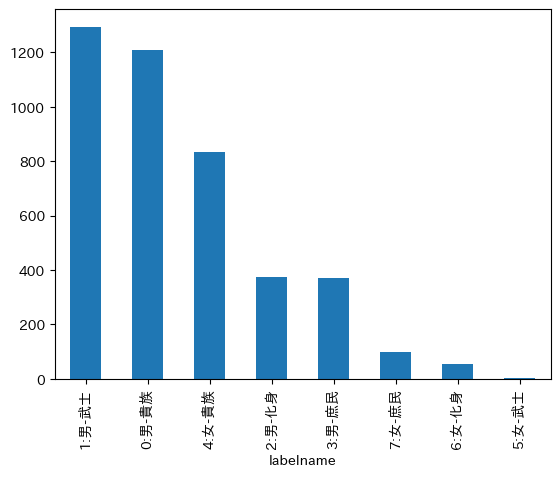

In [11]:
# ラベル量を棒グラフ化
data['labelname'].value_counts().plot.bar()

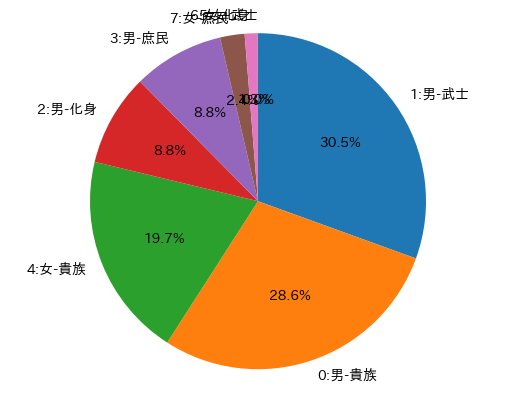

In [12]:
# 円グラフ(カテゴリ割合)
sizes     = data['labelname'].value_counts(sort=True)
labels    = data['labelname'].value_counts(sort=True).index.tolist()
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, shadow=False, counterclock=False)
ax1.axis('equal')
plt.show()

## csvファイルからデータセットを読み込むクラス

In [13]:
# csvからデータセットを読み込むためのクラス定義
class LoadDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
      imgfile   = self.dataframe.loc[idx, 'image']
      imgpath   = self.dataframe.loc[idx, 'imagePath']
      label     = self.dataframe.loc[idx, 'gender_status']
      labelname = self.dataframe.loc[idx, 'labelname']
      # 画像の読み込み
      img = Image.open(imgpath).convert('RGB')

      if self.transform:
          img = self.transform(img)
      return img, label, imgfile, labelname

### テストとして画像を何枚か表示してみる

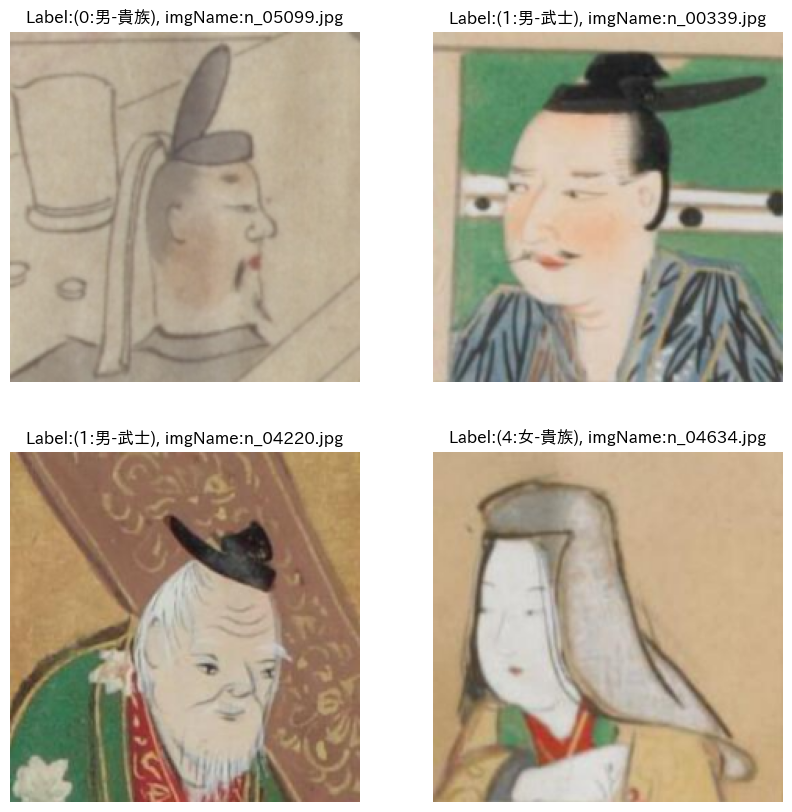

In [14]:
# ロードテスト用の画像の前処理
loadtest_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 画像サイズをモデルに合わせて変更
    transforms.ToTensor(),
])

# ロードテスト用のデータセットの作成
loadtest_dataset    = LoadDataset(dataframe=data, transform=loadtest_transform)
loadtest_batch_size = 4

# ロードテスト用のデータローダーの作成
loadtest_dataloader = DataLoader(loadtest_dataset, batch_size=loadtest_batch_size, shuffle=True)

# 画像の表示（今回は2x2のgrid（計4枚）表示する）
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, (inputs, labels, imgPaths, labelnames) in enumerate(loadtest_dataloader):
    for j in range(4):
        img       = inputs[j].permute(1, 2, 0)  # チャンネルを最後に移動
        label     = labels[j].item()
        imgPath   = imgPaths[j]
        labelname = labelnames[j]
        axs[i * 2 + j // 2, j % 2].imshow(img)
        axs[i * 2 + j // 2, j % 2].set_title(f"Label:({labelname}), imgName:{imgPath}")
        axs[i * 2 + j // 2, j % 2].axis('off')
    break
plt.show()